In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using UMAP, Muon
using Distances
using SPI
using DataFrames, CSV
using StatsBase
using StatsPlots
theme(:default, grid=false, framestyle=:box, label="", ratio=1)

In [2]:
ddir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "UMAPof669isolates_nostainvariation") |> mkpath
pdir = plotsdir("UMAPof669isolates_nostainvariation") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [3]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [4]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.030226667349341582

In [5]:
donorid = biobank.obs.donor
familyid = biobank.obs.family_ncbi
replace!(familyid, "<unclassified>" => "<unknown family>");

In [6]:
sort(countmap(familyid), byvalue=true, rev=true)

OrderedCollections.OrderedDict{String, Int64} with 12 entries:
  "Lachnospiraceae"              => 347
  "Bacteroidaceae"               => 229
  "Bifidobacteriaceae"           => 30
  "Tannerellaceae"               => 21
  "Prevotellaceae"               => 14
  "Rikenellaceae"                => 9
  "Erysipelotrichaceae"          => 5
  "Oscillospiraceae"             => 4
  "<unknown family>"             => 4
  "Odoribacteraceae"             => 4
  "Enterobacteriaceae"           => 1
  "Eubacteriales incertae sedis" => 1

In [7]:
csb_mtx = biobank["oggs"].X[:,:]
bbusv_csb = svd(csb_mtx);

In [8]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100

669-element Vector{Float64}:
 68.57432635553661
 16.144493635283414
  1.6177318590582548
  1.404387230237807
  1.2059400001284466
  0.8479472643879468
  0.7602421579353728
  0.7002405381427051
  0.6578864258462969
  0.6102826214803199
  ⋮
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31
  5.468870496580899e-31

In [9]:
sum(pctvar[1:2])

84.71881999082002

In [10]:
sum(pctvar[1:10])

92.52347808803717

In [11]:
keptspecies = string.(keys(sort(filter(x-> last(x) > 19, countmap(biobank.obs.species)), byvalue=true, rev=true)))
filter!(!=("unclassified"), keptspecies)
full_train_mask = in.(biobank.obs.species, Ref(keptspecies));
full_test_mask = .!(full_train_mask);
bbobs_trn = biobank.obs[full_train_mask, :];

In [12]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(bbobs_trn.species)), specieslabels), nothing=>9)])

In [105]:
species_labelscounts = map(specieslabels[Not(9)]) do label
    cnt = occursin.(biobank.obs.species, label) |> sum
    label, cnt
end |> x->sort(x, by=last, rev=true)

9-element Vector{Tuple{String, Int64}}:
 ("Phocaeicola vulgatus", 88)
 ("[Ruminococcus] gnavus", 41)
 ("Bacteroides thetaiotaomicron", 35)
 ("Anaerostipes hadrus", 31)
 ("Bacteroides uniformis", 27)
 ("Bifidobacterium breve", 24)
 ("Coprococcus comes", 23)
 ("Dorea formicigenerans", 22)
 ("[Eubacterium] rectale", 20)

In [13]:
orderedfamilylabels = stack(DataFrame(countmap(familyid)), 1:12) |>
    df -> DataFrames.transform(df, :value => (-) => :minusvalue) |>
    df -> sort(df, [:minusvalue, :variable], rev=false) |>
    df -> df.variable
familycolors = permutedims(palette(:Set3_12).colors.colors[indexin(sort(unique(familyid)), orderedfamilylabels)])

## Top PCs

In [14]:
using Random: seed!

In [15]:
sqrt(size(bbusv_csb, 1))

25.865034312755125

In [112]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
seed!(654321)
pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=size(bbusv_csb, 1)-1, metric=Euclidean())';

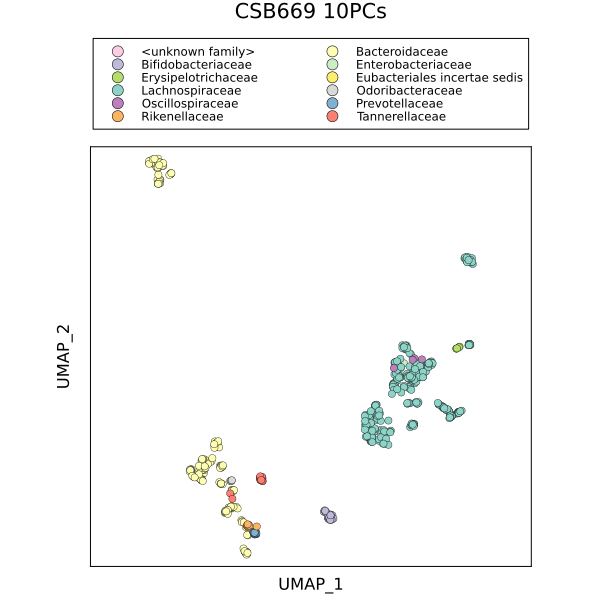

In [125]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [126]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_byfamily.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/UMAPof669isolates_nostainvariation/umap_top10PCs_669isolates_byfamily.pdf"

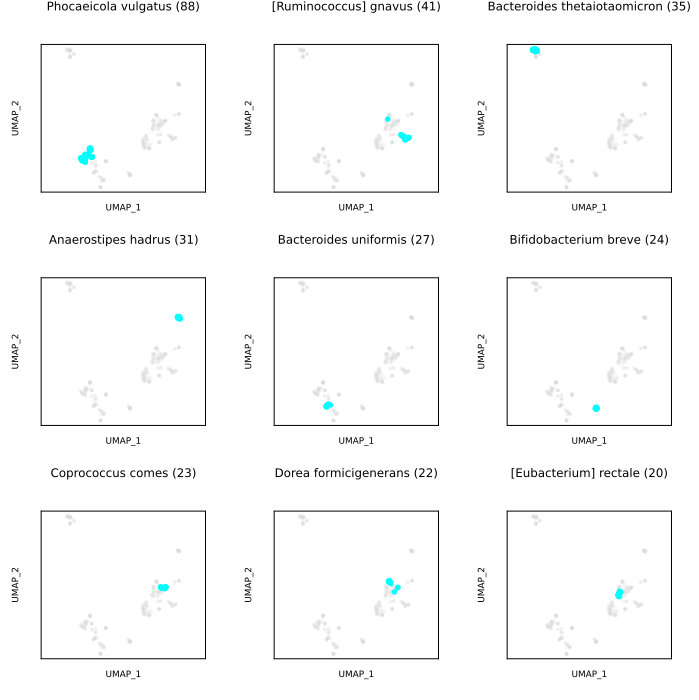

In [131]:
ps = []
for (label, cnt) in species_labelscounts
    mask = occursin.(biobank.obs.species, label)
    p = plot()
    scatter!(pcs_coords[.!mask, 1], pcs_coords[.!mask, 2]; c=:lightgrey, alpha=.1, markersize=2, markerstrokewidth=0)
    scatter!(pcs_coords[mask, 1], pcs_coords[mask, 2];
        title="$label ($cnt)", 
        c=:aqua,
        alpha=1, 
        markersize=3, 
        markerstrokewidth=0, 
    )
    push!(ps, p)
end
plot(ps...;
    layout=grid(3,3),
    size=(700,700),
    supertitle="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
    titlefontsize=8,
    labelfontsize=6,
    ticks=false,
    margin=5Plots.mm,

)

In [132]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_highlight_species.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/UMAPof669isolates_nostainvariation/umap_top10PCs_669isolates_highlight_species.pdf"

## PC plots

In [117]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [118]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';

669×669 Matrix{Float64}:
 -112.801   -27.3099    6.49124   -3.15766   …   0.0           0.0
 -159.456   -46.9128    3.53239   -1.87018       1.0956e-29   -4.09501e-31
 -156.299   -42.0726    1.4705    -1.16948       5.63712e-30  -5.59961e-30
 -153.112   -43.5201   12.164    -18.3103       -1.74158e-15  -3.81379e-16
 -168.229   -47.8656   -5.39674   10.4025       -8.40292e-29   5.45697e-29
 -167.986   -47.5712   -5.44556   10.4161    …   7.9556e-29   -7.06648e-29
 -216.735   -63.5251  -21.9006    27.6561        7.07672e-29   2.47008e-29
 -164.946   -48.1611   12.2325   -19.6862       -6.14271e-30   4.34912e-30
 -228.609   -74.9903  -24.0148    32.894        -9.90552e-29   7.91465e-30
 -155.459   -45.0148   15.0988   -22.88         -1.38605e-30   6.64476e-30
    ⋮                                        ⋱                
 -142.905   -47.3843   13.6441     1.95936   …   4.03214e-30  -1.00016e-30
 -144.232   -47.0175   13.7384     1.68935      -1.70106e-29  -1.23642e-30
 -224.707   -74.3895

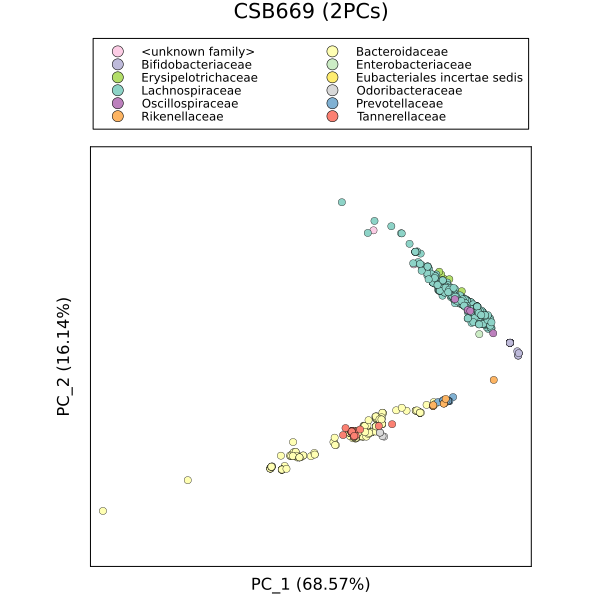

In [119]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [120]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_byfamily.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/UMAPof669isolates_nostainvariation/PCplot_PCs1and2_669isolates_byfamily.pdf"

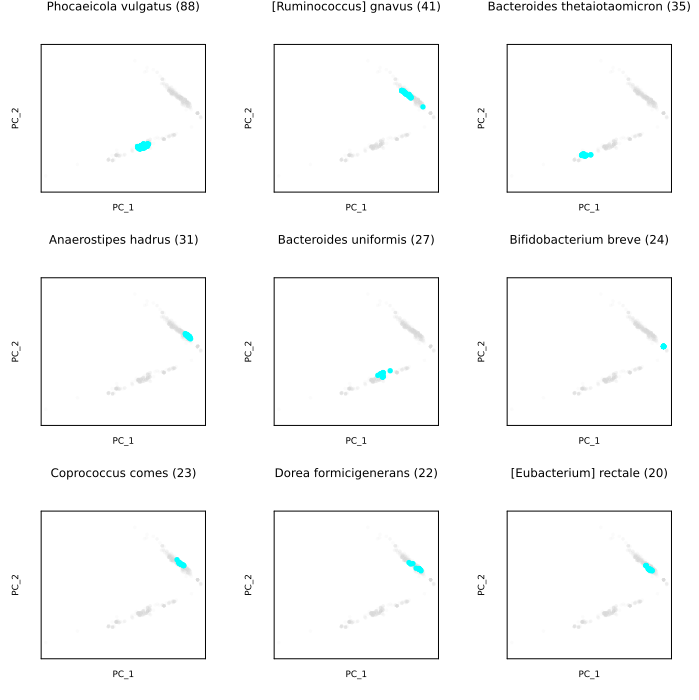

In [133]:
ps = []
for (label, cnt) in species_labelscounts
    mask = occursin.(biobank.obs.species, label)
    p = plot()
    scatter!(pcs_csb[.!mask, 1], pcs_csb[.!mask, 2]; c=:lightgrey, alpha=.1, markersize=2, markerstrokewidth=0)
    scatter!(pcs_csb[mask, 1], pcs_csb[mask, 2];
        title="$label ($cnt)", 
        c=:aqua,
        alpha=1, 
        markersize=3, 
        markerstrokewidth=0, 
    )
    push!(ps, p)
end
plot(ps...;
    layout=grid(3,3),
    size=(700,700),
    supertitle="CSB669 10PCs",
    xlabel="PC_1",
    ylabel="PC_2",
    titlefontsize=8,
    labelfontsize=6,
    ticks=false,
    margin=5Plots.mm,

)

In [134]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_highlight_species.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/UMAPof669isolates_nostainvariation/PCplot_PCs1and2_669isolates_highlight_species.pdf"